# Generowanie danych testowych

In [1]:
from src.prepare_datasets import prepare_2_mix_dataset
import numpy as np

embeddings = np.load('data/embeddings_val.npy')
prepare_2_mix_dataset('data/2mix_val', embeddings, 5, 10, 4, 8, n=1000, sr=16000, seed=42, dataset='val')

100%|██████████| 1000/1000 [00:22<00:00, 44.70it/s]


In [3]:
import librosa

total_duration = 0
for i in range(1000):
    duration = librosa.get_duration(path=f'data/2mix_val/mixed/{i}.wav')
    total_duration += duration

print(f'Łączna długość wygenerowanych plików: {total_duration} sekund')

Łączna długość wygenerowanych plików: 8294.612000000003 sekund


# Przetwarzanie przez modele

In [4]:
import librosa
import torch
import numpy as np
from scipy.io.wavfile import write
from tqdm import tqdm
import time
import os

from src.metrics import get_SI_SDR

In [5]:
def match_size(ref_wav, gen_wav):
    if len(ref_wav) > len(gen_wav):
        gen_wav = np.pad(gen_wav, (0, len(ref_wav) - len(gen_wav)), 'constant')
    elif len(ref_wav) < len(gen_wav):
        gen_wav = gen_wav[:len(ref_wav)]
    return gen_wav

In [ ]:
def split_with_function(model, split_function, n=1000, sr=16000):
    times = []
    os.makedirs(f'data/2mix_val/{model}/speaker1', exist_ok=True)
    os.makedirs(f'data/2mix_val/{model}/speaker2', exist_ok=True)
    for i in tqdm(range(n)):
        mixed = librosa.load(f'data/2mix_val/mixed/{i}.wav', sr=sr)[0]
        ref1 = librosa.load(f'data/2mix_val/speaker1/{i}.wav', sr=sr)[0]
        ref2 = librosa.load(f'data/2mix_val/speaker2/{i}.wav', sr=sr)[0]

        start = time.perf_counter()
        speaker1, speaker2 = split_function(mixed)
        end = time.perf_counter()

        times.append(end - start)

        spk1 = match_size(ref1, speaker1)
        spk2 = match_size(ref2, speaker2)
        sdr1_1 = get_SI_SDR(ref1, spk1)
        sdr2_2 = get_SI_SDR(ref2, spk2)
        sdr1_2 = get_SI_SDR(ref1, spk2)
        sdr2_1 = get_SI_SDR(ref2, spk1)
        if sdr1_1 + sdr2_2 < sdr1_2 + sdr2_1:
            speaker1, speaker2 = speaker2, speaker1
        write(f'data/2mix_val/{model}/speaker1/{i}.wav', sr, speaker1)
        write(f'data/2mix_val/{model}/speaker2/{i}.wav', sr, speaker2)
    
    return np.mean(times)

### Mossformer2

In [2]:
import sys
sys.path.append('src/mossformer2')

from src.mossformer2.mossformer2 import MossFormer2_adapted

mossformer_16 = MossFormer2_adapted('src/mossformer2/checkpoints')

c:\Studia\Master_Thesis\src\mossformer2\mossformer2_utils.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


In [3]:
def split_with_mossformer2(input):
    spk1, spk2 = mossformer_16(np.array([input]))
    return spk1, spk2

In [23]:
mossformer2_time = split_with_function('mossformer2', split_with_mossformer2, n=1000, sr=16000)

100%|██████████| 1000/1000 [51:33<00:00,  3.09s/it] 


In [ ]:
print(f'Mossformer2 time per sample: {mossformer2_time}')
print(f'Mossformer2 RDF: {mossformer2_time * 1000 / total_duration}')

Mossformer2 time per sample: 1.7627906935003121
Mossformer2 RDF: 0.212522381215699


### Sepreformer

In [3]:
from src.sepreformer.sepreformer import SepReformer
sepreformer = SepReformer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def split_with_sepreformer(input):
    input = torch.Tensor(input).to(device)
    spk1, spk2 = np.array(sepreformer(input))
    return spk1, spk2

In [7]:
sepreformer_time = split_with_function('sepreformer', split_with_sepreformer, n=1000, sr=8000)

100%|██████████| 1000/1000 [10:50<00:00,  1.54it/s]


In [ ]:
print(f'SepReformer time per sample: {sepreformer_time}')
print(f'SepReformer RDF: {sepreformer_time * 1000 / total_duration}')

SepReformer time per sample: 0.6439174992999469
SepReformer RDF: 0.07763081616113529


### Fast-GeCo

In [9]:
from src.fastgeco.fastgeco import GeCo

fastgeco = GeCo('src/fastgeco/Fast-GeCo/checkpoints')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Studia\Master_Thesis\src\fastgeco\Fast-GeCo\checkpoints\fastgeco.ckpt`


In [10]:
def split_with_fastgeco(input):
    input = torch.Tensor(input).unsqueeze(0).to(device)
    spk1, spk2 = fastgeco(input)
    return np.array(spk1.cpu()), np.array(spk2.cpu())

In [7]:
fastgeco_time = split_with_function('fastgeco', split_with_fastgeco, n=1000, sr=8000)

100%|██████████| 1000/1000 [32:22<00:00,  1.94s/it] 


In [ ]:
print(f'Fast-GeCo time per sample: {fastgeco_time}')
print(f'Fast-GeCo RDF: {fastgeco_time * 1000 / total_duration}')

Fast-GeCo time per sample: 1.934825124199977
Fast-GeCo RDF: 0.23326288489443223


# TF-Locoformer

In [2]:
import sys
sys.path.append('src')

from src.espnet.espnet2.bin.enh_inference import SeparateSpeech


locoformer = SeparateSpeech(
    train_config='src/espnet/egs2/wsj0_2mix/enh1/exp/enh_train_enh_tflocoformer_pretrained/config.yaml',
    model_file='src/espnet/egs2/wsj0_2mix/enh1/exp/enh_train_enh_tflocoformer_pretrained/valid.loss.ave_5best.pth',
    normalize_output_wav=True,
    device="cuda:0",
)

c:\Studia\Master_Thesis\src\espnet\espnet2\enh\loss\criterions\time_domain.py:446: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
c:\Studia\Master_Thesis\src\espnet\espnet2\enh\layers\tcn.py:458: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
c:\Studia\Master_Thesis\src\espnet\espnet2\enh\layers\tcn.py:499: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
c:\Studia\Master_Thesis\src\espnet\espnet2\enh\layers\uses.py:392: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
c:\Studia\Master_Thesis\src\espnet\espnet2\enh\layers\uses

In [10]:
def split_with_locoformer(input):
    input /= input.std(axis=-1)
    spk1, spk2 = locoformer(input[None], 8000)
    return np.array(spk1[0]), np.array(spk2[0])

In [11]:
locoformer_time = split_with_function('locoformer', split_with_locoformer, n=1000, sr=8000)

100%|██████████| 1000/1000 [13:24<00:00,  1.24it/s]


In [ ]:
print(f'TF-Locoformer time per sample: {locoformer_time}')
print(f'TF-Locoformer RDF: {locoformer_time * 1000 / total_duration}')

TF-Locoformer time per sample: 0.7774182071999821
TF-Locoformer RDF: 0.09372568689168123


# Mierzenie metryk

In [14]:
import pandas as pd
import torch
import json

In [15]:
import whisper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transcription_model = whisper.load_model("turbo", device=device)

c:\Studia\.conda\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [18]:
ref_files1 = [f'data/2mix_val/speaker1/{i}.wav' for i in range(1000)]
ref_files2 = [f'data/2mix_val/speaker2/{i}.wav' for i in range(1000)]
mixed_files = [f'data/2mix_val/mixed/{i}.wav' for i in range(1000)]

est_files1 = [{model: f'data/2mix_val/{model}/speaker1/{i}.wav' for model in ['mossformer2', 'sepreformer', 'fastgeco', 'locoformer']} for i in range(1000)]
est_files2 = [{model: f'data/2mix_val/{model}/speaker2/{i}.wav' for model in ['mossformer2', 'sepreformer', 'fastgeco', 'locoformer']} for i in range(1000)]

texts_df = pd.read_csv('data/2mix_val/texts.csv')
texts1 = list(texts_df['text1'])
texts2 = list(texts_df['text2'])

In [16]:
from src.metrics import calculate_metrics

In [24]:
results_spk1 = calculate_metrics(ref_files1, est_files1, mixed_files, sr=16000, texts=texts1, transcription_model=transcription_model)
with open('results/spk1_16kHz.jsonl', 'w') as jsonl_file:
    for file_result in results_spk1:
        jsonl_file.write(json.dumps(file_result) + '\n')

100%|██████████| 1000/1000 [1:34:56<00:00,  5.70s/it]


In [25]:
results_spk2 = calculate_metrics(ref_files2, est_files2, mixed_files, sr=16000, texts=texts2, transcription_model=transcription_model)
with open('results/spk2_16kHz.jsonl', 'w') as jsonl_file:
    for file_result in results_spk2:
        jsonl_file.write(json.dumps(file_result) + '\n')

100%|██████████| 1000/1000 [1:35:28<00:00,  5.73s/it]


In [26]:
results_spk1_8kHz = calculate_metrics(ref_files1, est_files1, mixed_files, sr=8000, texts=texts1, transcription_model=transcription_model)
with open('results/spk1_8kHz.jsonl', 'w') as jsonl_file:
    for file_result in results_spk1_8kHz:
        jsonl_file.write(json.dumps(file_result) + '\n')

100%|██████████| 1000/1000 [1:26:44<00:00,  5.20s/it]


In [5]:
results_spk2_8kHz = calculate_metrics(ref_files2, est_files2, mixed_files, sr=8000, texts=texts2, transcription_model=transcription_model)
with open('results/spk2_8kHz.jsonl', 'w') as jsonl_file:
    for file_result in results_spk2_8kHz:
        jsonl_file.write(json.dumps(file_result) + '\n')

100%|██████████| 1000/1000 [1:11:43<00:00,  4.30s/it]


In [20]:
def load_as_df_per_model(path):
    results = []
    with open(path, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    metrics_order = ['SDR', 'SDRi', 'SI-SDR', 'SI-SDRi', 'MCD', 'PESQ', 'STOI', 'SIM', 'WER', 'CER', 'MSS', 'SI-MSS']

    all_models = list(results[0].keys())

    all_results = {model: [] for model in all_models}
    for model in all_models:
        for i in range(len(results)):
            all_results[model].append(results[i][model])

    all_results = {model: pd.DataFrame(all_results[model])[metrics_order] for model in all_models}
    return all_results

In [21]:
def get_df(all_results):
    results_df = []
    for model, df in all_results.items():
        results_df.append(df.mean().to_dict())
    results_df = pd.DataFrame(results_df, index=all_results.keys()).T
    return results_df

In [27]:
all_results_spk1_16kHz = load_as_df_per_model('results/spk1_16kHz.jsonl')
all_results_spk2_16kHz = load_as_df_per_model('results/spk2_16kHz.jsonl')
all_results_spk1_8kHz = load_as_df_per_model('results/spk1_8kHz.jsonl')
all_results_spk2_8kHz = load_as_df_per_model('results/spk2_8kHz.jsonl')

df_spk1_16kHz = get_df(all_results_spk1_16kHz)
df_spk2_16kHz = get_df(all_results_spk2_16kHz)
df_spk1_8kHz = get_df(all_results_spk1_8kHz)
df_spk2_8kHz = get_df(all_results_spk2_8kHz)

In [28]:
df_spk1_16kHz

,mossformer2,sepreformer,fastgeco,locoformer
SDR,17.817959,-16.147867,8.857065,-5.369058
SDRi,16.550386,-17.415440,7.589492,-6.636631
SI-SDR,17.747915,-6.278158,8.412730,8.080125
SI-SDRi,17.701610,-6.324462,8.366425,8.033820
MCD,1.633084,15.863658,4.447881,4.336262
PESQ,2.855740,1.343305,1.721052,1.819214
STOI,0.955599,0.613820,0.894139,0.897523
SIM,0.962364,0.595707,0.896751,0.903382
WER,0.122521,0.755167,0.263607,0.238422
CER,0.066768,0.568069,0.166482,0.153777


In [29]:
df_spk2_16kHz

,mossformer2,sepreformer,fastgeco,locoformer
SDR,17.816785,-15.920581,8.789560,-5.393590
SDRi,16.609066,-17.128300,7.581841,-6.601309
SI-SDR,17.763171,-6.428062,8.392899,8.038233
SI-SDRi,17.803590,-6.387643,8.433318,8.078652
MCD,1.964485,15.495453,4.473781,4.374540
PESQ,2.905205,1.511128,1.752069,1.847359
STOI,0.957837,0.607067,0.897270,0.899895
SIM,0.959883,0.580933,0.895911,0.897696
WER,0.126430,0.762645,0.270411,0.251613
CER,0.070296,0.567393,0.172687,0.163663


In [30]:
df_spk1_8kHz

,mossformer2,sepreformer,fastgeco,locoformer
SDR,18.669895,-16.412555,11.314107,-5.561434
SDRi,17.402147,-17.680303,10.046360,-6.829181
SI-SDR,18.645064,-4.946832,11.528687,11.672073
SI-SDRi,18.593752,-4.998144,11.477374,11.620761
MCD,1.633084,15.863658,4.447881,4.336262
PESQ,3.087825,1.543568,2.199584,2.409659
STOI,0.955518,0.615723,0.898344,0.901728
SIM,0.957963,0.595286,0.897490,0.902687
WER,0.133816,0.751697,0.263870,0.238764
CER,0.074301,0.566127,0.166139,0.153793


In [31]:
df_spk2_8kHz

,mossformer2,sepreformer,fastgeco,locoformer
SDR,18.682316,-16.189514,11.275267,-5.591490
SDRi,17.487300,-17.384529,10.080252,-6.786505
SI-SDR,18.674523,-5.082241,11.552381,11.652954
SI-SDRi,18.718948,-5.037816,11.596806,11.697379
MCD,1.964485,15.495453,4.473781,4.374540
PESQ,3.134962,1.727306,2.262788,2.461264
STOI,0.957616,0.608885,0.901326,0.904049
SIM,0.955444,0.580958,0.895799,0.897613
WER,0.135939,0.763242,0.270161,0.252144
CER,0.076958,0.567317,0.172705,0.163936


In [32]:
df = pd.read_csv('data/2mix_val/texts.csv')
df['text_len1'] = df['text1'].apply(lambda x: len(x.split()))
df['text_len2'] = df['text2'].apply(lambda x: len(x.split()))
df['overlap_len'] = df['duration1'] + df['duration2'] - df['duration']
df['context1'] = df['duration'] - df['duration2']
df['context2'] = df['duration'] - df['duration1']
df['overlap_ratio'] = df['overlap_len'] / df['duration']
df['text_speed1'] = df['text_len1'] / df['duration1']
df['text_speed2'] = df['text_len2'] / df['duration2']
df['avg_text_speed'] = (df['text_len1'] + df['text_len2']) / (df['duration1'] + df['duration2'])

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dependencies(data_feature, metric, sharey=True):
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=sharey)
    
    for i, (model, model_df) in enumerate(all_results_spk1_8kHz.items()):
        ax = axs[i//2, i%2]
        ax.scatter(df[data_feature], model_df[metric], alpha=0.5, color='blue', s=10, label='speaker 1')
        ax.set_title(f'{model}')
        ax.set_xlabel(data_feature)
        ax.set_ylabel(metric)
        ax.grid(True)
        
    for i, (model, model_df) in enumerate(all_results_spk2_8kHz.items()):
        ax = axs[i//2, i%2]
        ax.scatter(df[data_feature], model_df[metric], alpha=0.5, color='red', s=10, label='speaker 2')

    plt.tight_layout()
    plt.show()    

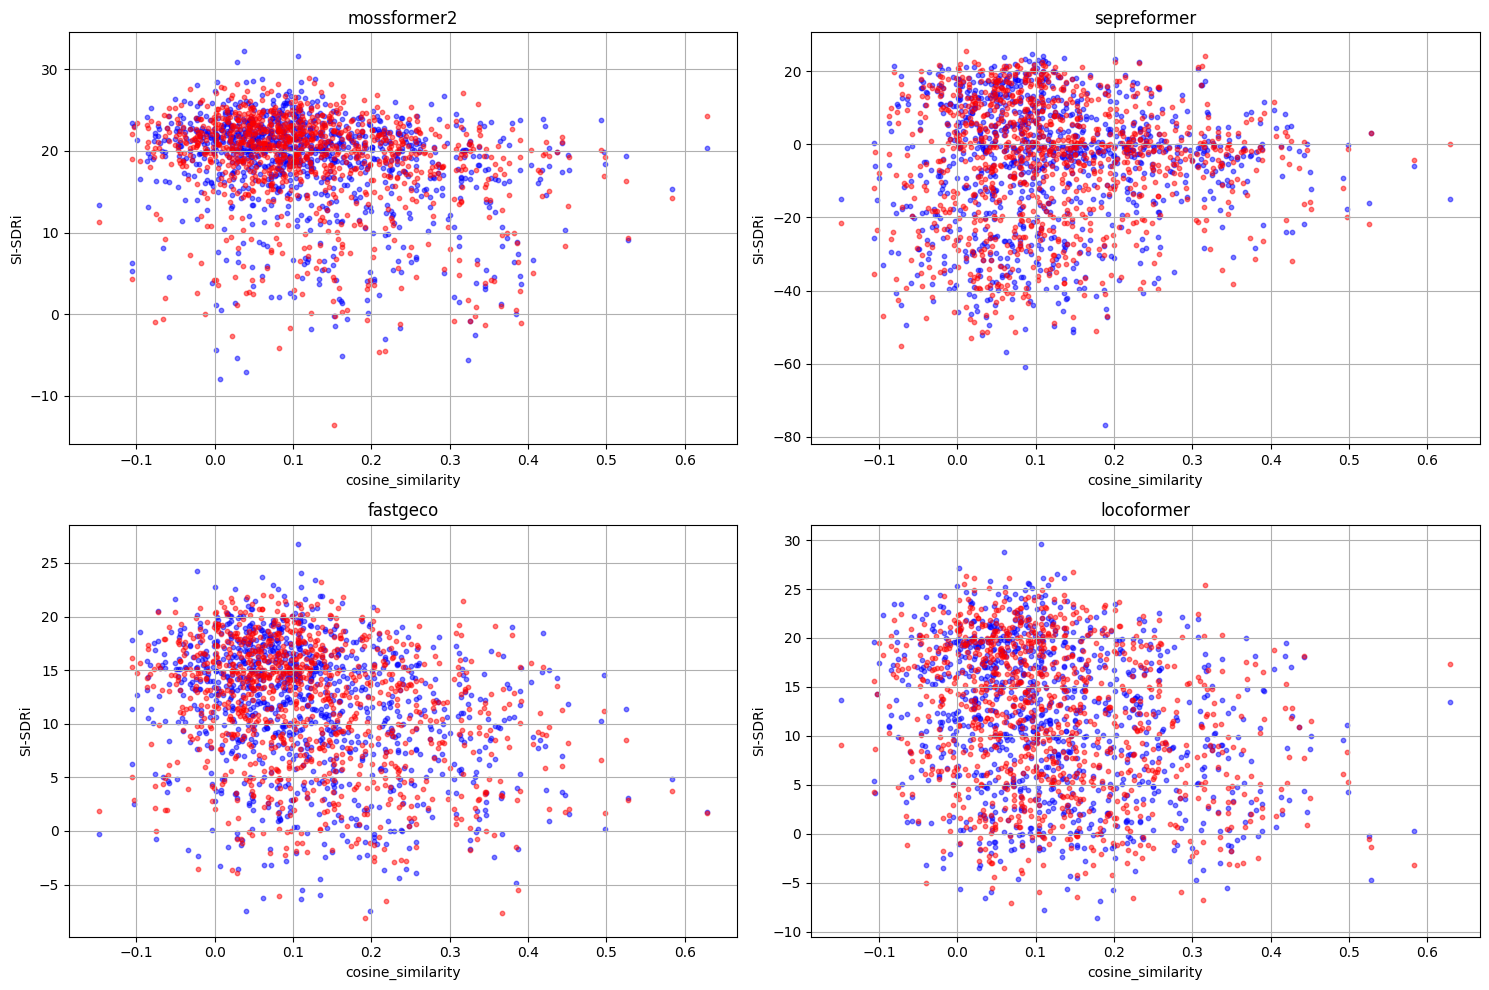

In [42]:
plot_dependencies('cosine_similarity', 'SI-SDRi', False)

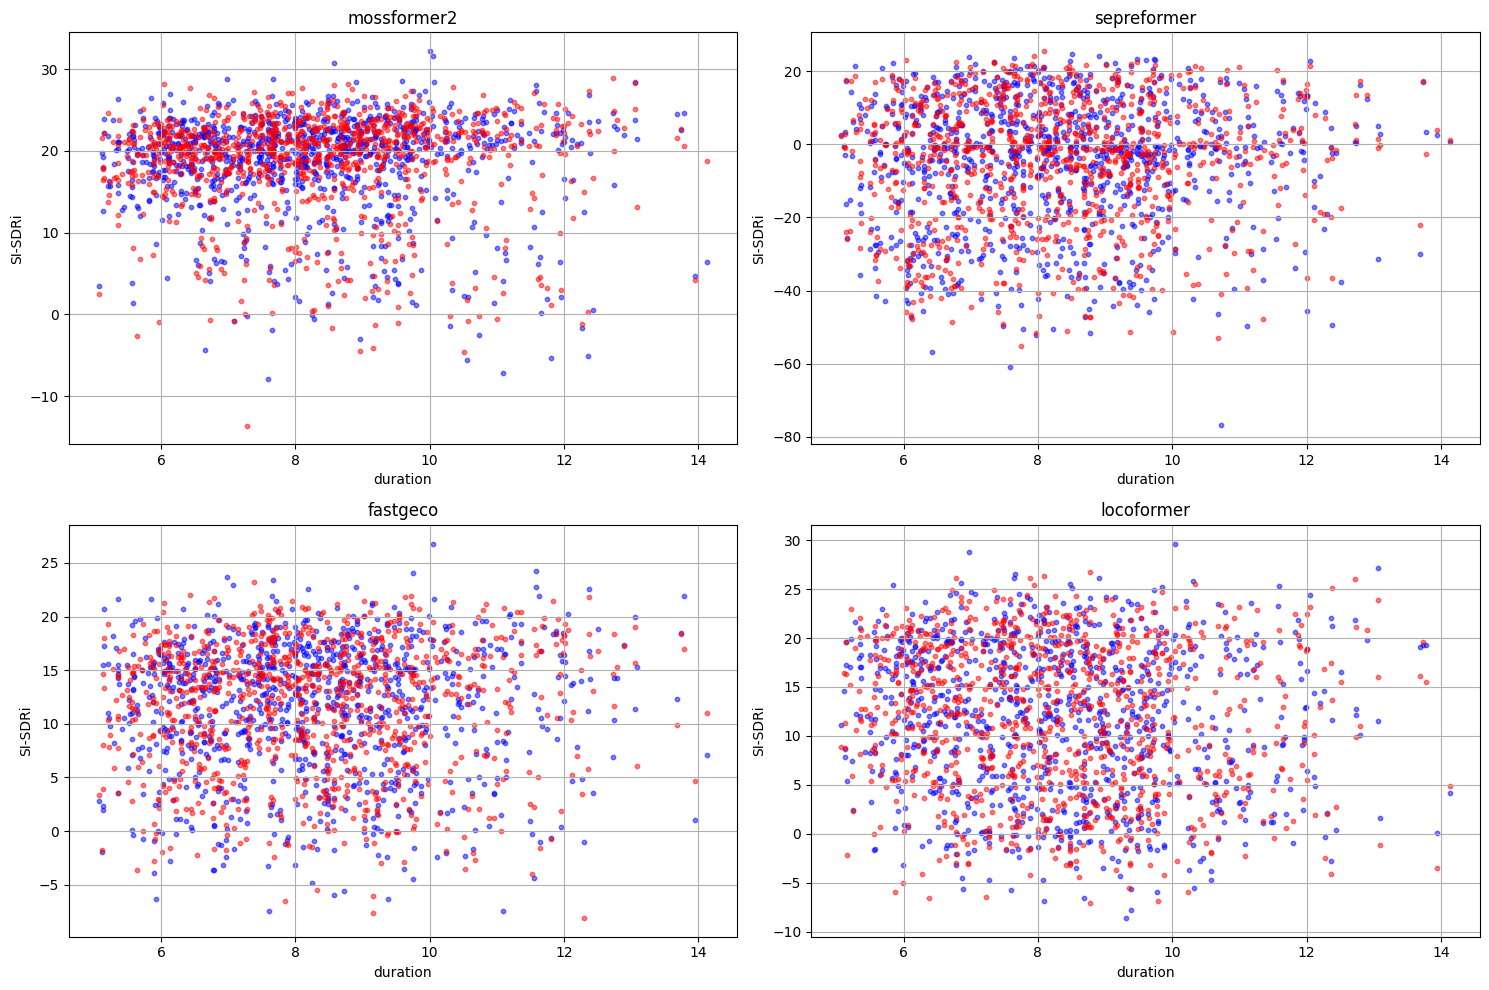

In [43]:
plot_dependencies('duration', 'SI-SDRi', False)

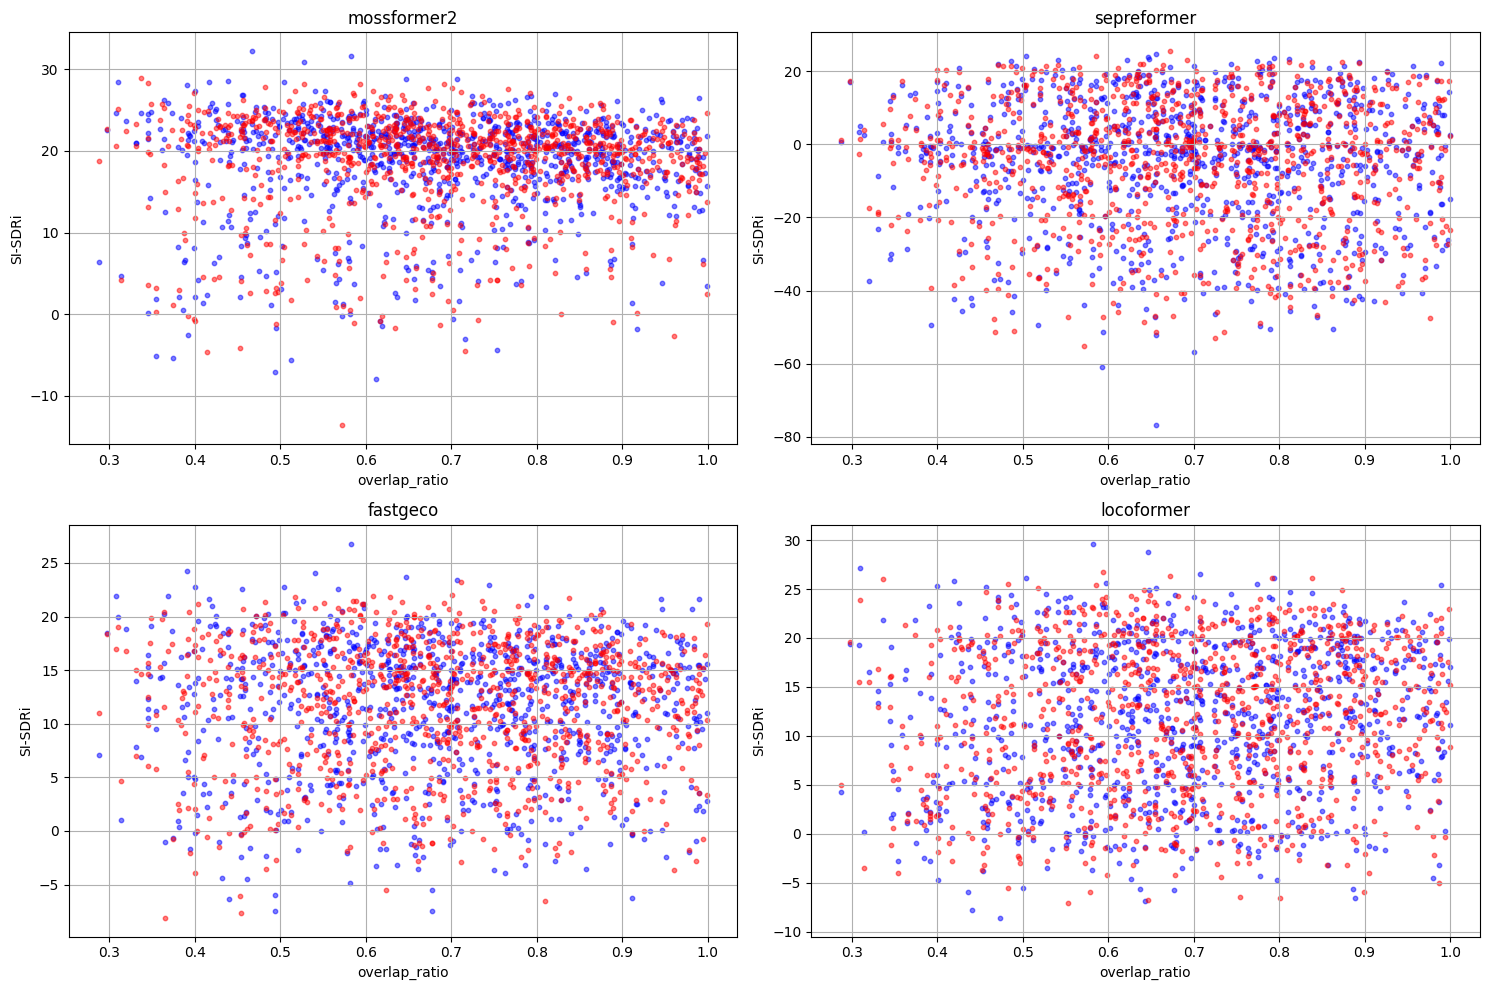

In [44]:
plot_dependencies('overlap_ratio', 'SI-SDRi', False)

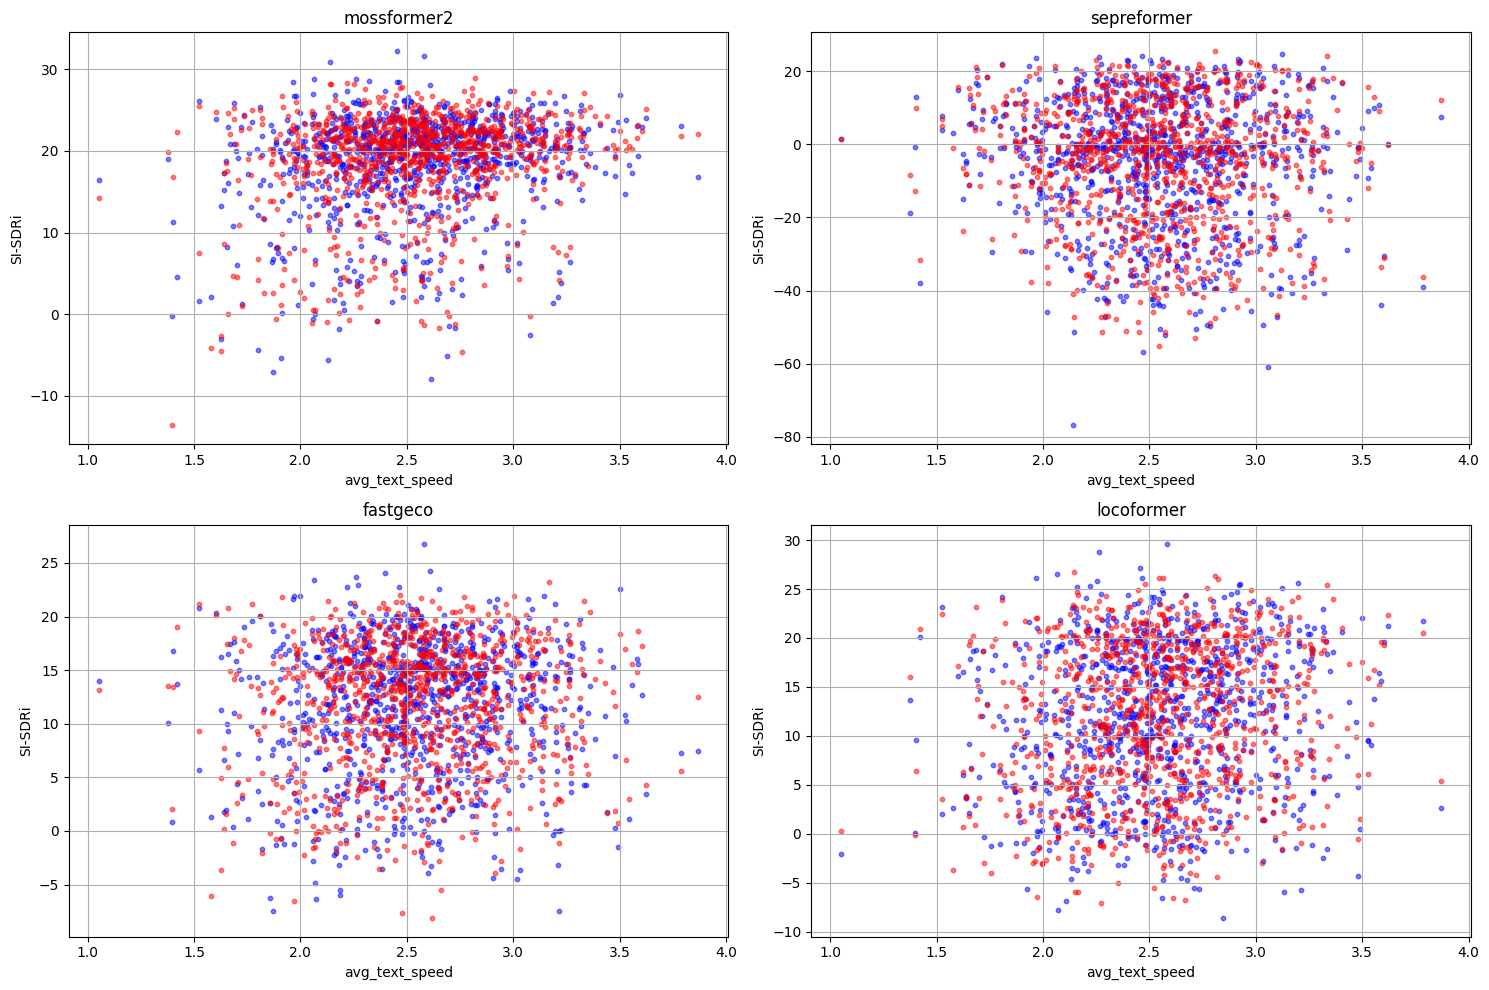

In [45]:
plot_dependencies('avg_text_speed', 'SI-SDRi', False)

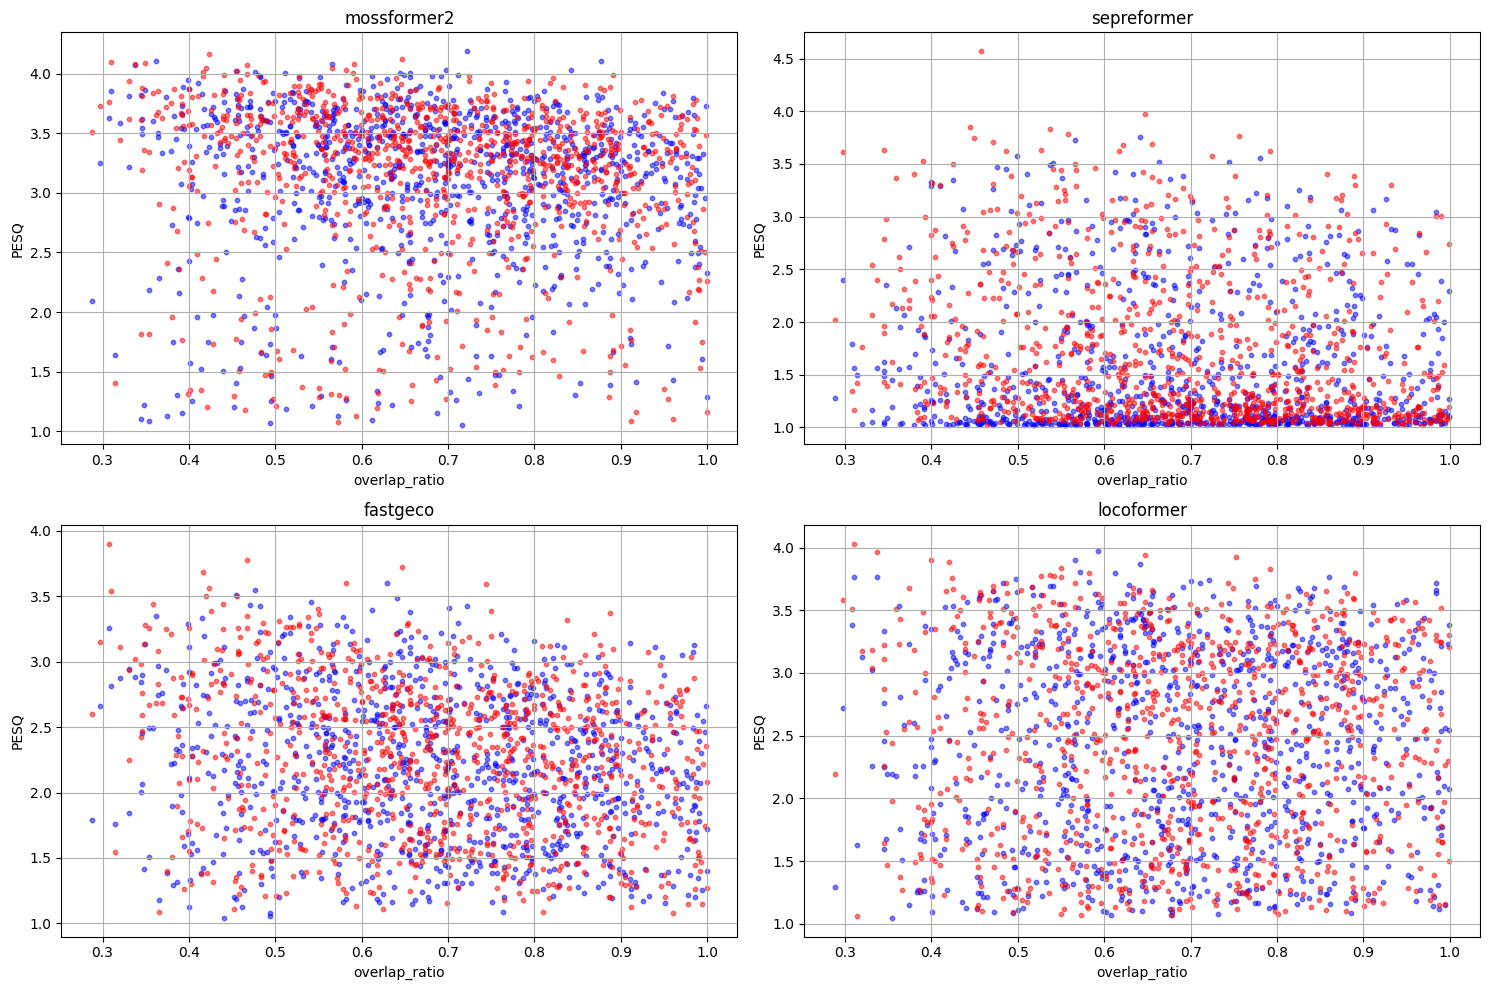

In [46]:
plot_dependencies('overlap_ratio', 'PESQ', False)

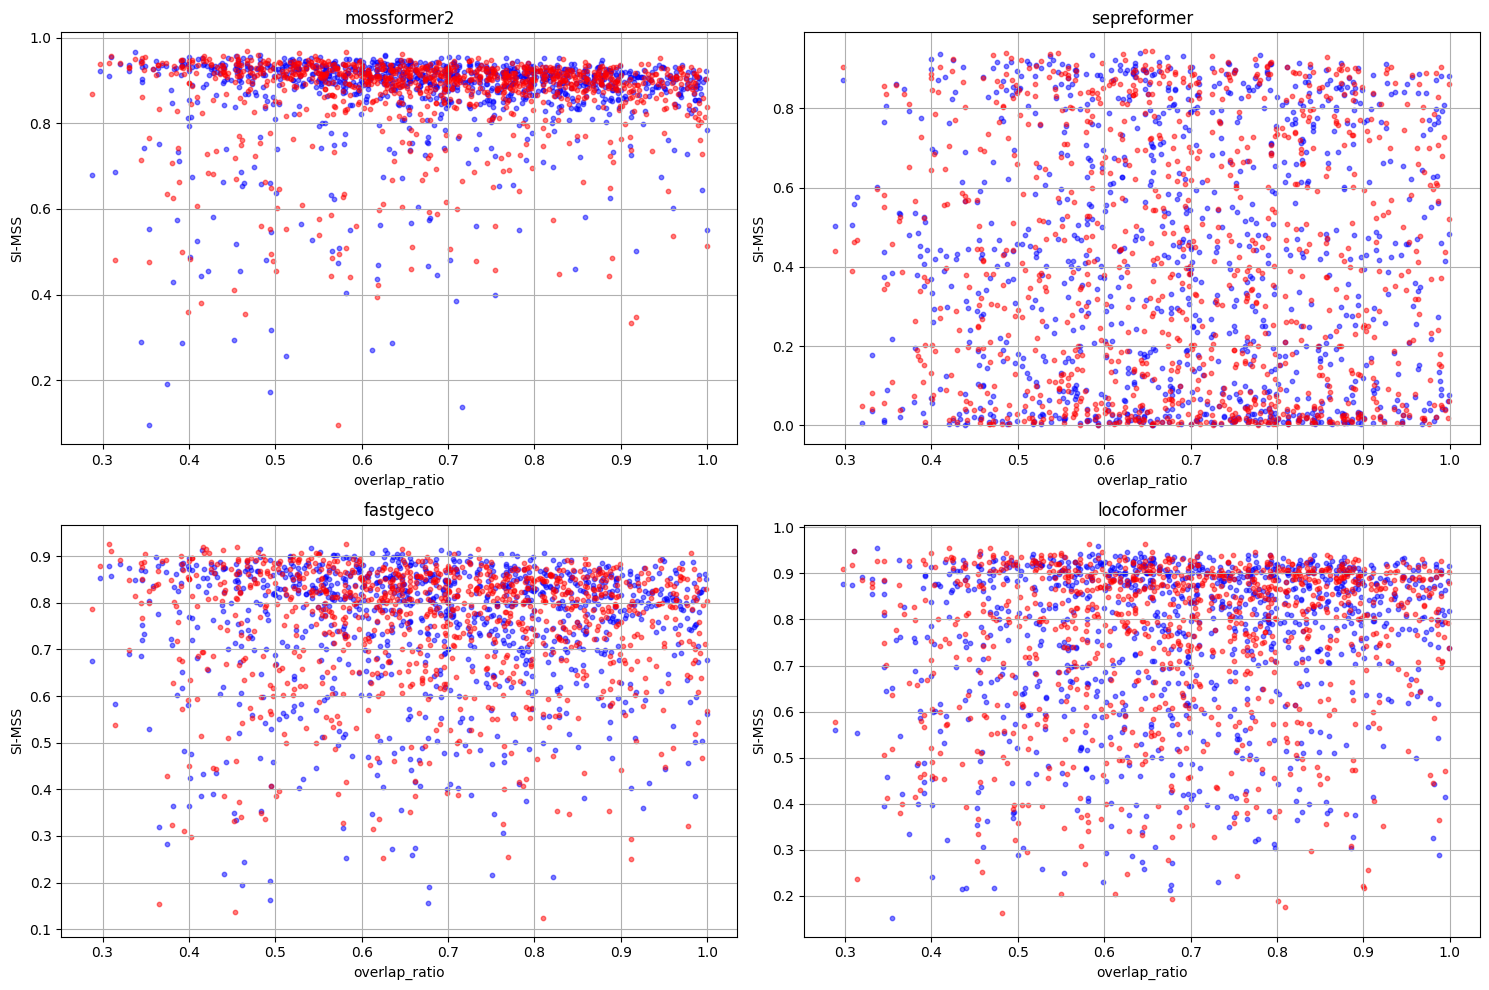

In [47]:
plot_dependencies('overlap_ratio', 'SI-MSS', False)

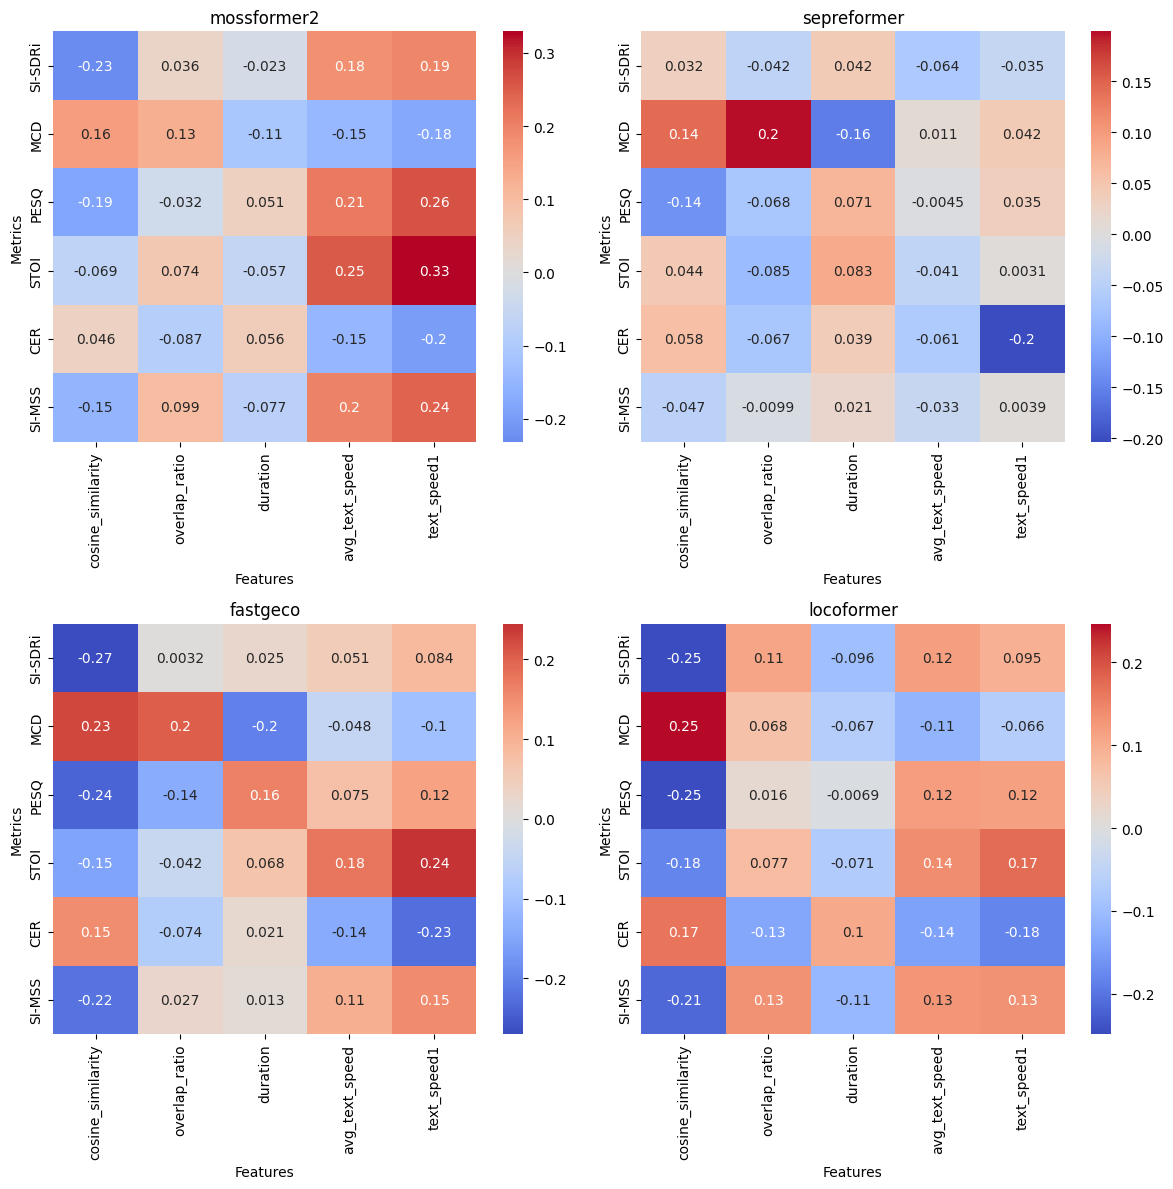

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_metric_correlations(df, models_results, feature_list, metric_list, model_names):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for idx, model_name in enumerate(model_names):
        ax = axs[idx//2, idx%2]
        model_df = models_results[model_name]
        
        combined_df = df[feature_list].copy()
        for metric in metric_list:
            combined_df[metric] = model_df[metric]
        
        corr = combined_df.corr()

        corr = corr.loc[feature_list, metric_list].T

        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title(model_name)
        ax.set_ylabel('Metrics')
        ax.set_xlabel('Features')

    plt.tight_layout()
    plt.show()

plot_feature_metric_correlations(df, all_results_spk1_8kHz, ['cosine_similarity', 'overlap_ratio', 'duration', 'avg_text_speed', 'text_speed1'], ['SI-SDRi', 'MCD', 'PESQ', 'STOI', 'CER', 'SI-MSS'], ['mossformer2', 'sepreformer', 'fastgeco', 'locoformer'])

# Test na próbkach negatywnych

In [50]:
import pandas as pd
from tqdm import tqdm
import numpy as np

df = pd.read_csv('data/metadata.csv')
df_sample = df.sample(100, random_state=42)

In [51]:
def check_negative_for_model(split_function, sr=8000):
    sdrs = []
    sdrs_spk = []
    for file in tqdm(df_sample['file']):
        wav = librosa.load(f'data/voices/{file}.wav', sr=sr)[0]
        ref = np.concatenate([wav, np.zeros_like(wav)])
        speaker1, speaker2 = split_function(wav)
        spk1 = match_size(wav, speaker1)
        spk2 = match_size(wav, speaker2)
        sdr1 = get_SI_SDR(ref, np.concatenate([spk1, spk2]))
        sdr2 = get_SI_SDR(ref, np.concatenate([spk2, spk1]))
        sdrs.append(max(sdr1, sdr2))
        sdrs_spk.append(max(get_SI_SDR(wav, spk1), get_SI_SDR(wav, spk2)))
    return np.mean(sdrs), np.mean(sdrs_spk)

In [31]:
mossformer2_negative, mossformer2_negative_spk = check_negative_for_model(split_with_mossformer2, 16000)
print('SI-SDR dla próbek negatywnych dla mossformer2:', mossformer2_negative)
print('SI-SDR dla próbek negatywnych dla mossformer2 (spk):', mossformer2_negative_spk)

100%|██████████| 100/100 [04:26<00:00,  2.66s/it]

SI-SDR dla próbek negatywnych dla mossformer2: 28.949335931241514
SI-SDR dla próbek negatywnych dla mossformer2 (spk): 29.93487403988838


In [32]:
sepreformer_negative, sepreformer_negative_spk = check_negative_for_model(split_with_sepreformer)
print('SI-SDR dla próbek negatywnych dla sepreformer:', sepreformer_negative)
print('SI-SDR dla próbek negatywnych dla sepreformer (spk):', sepreformer_negative_spk)

100%|██████████| 100/100 [01:03<00:00,  1.56it/s]

SI-SDR dla próbek negatywnych dla sepreformer: 16.29394329211209
SI-SDR dla próbek negatywnych dla sepreformer (spk): 20.101707535982133


In [14]:
fastgeco_negative, fastgeco_negative_spk = check_negative_for_model(split_with_fastgeco)
print('SI-SDR dla próbek negatywnych dla Fast-GeCo:', fastgeco_negative)
print('SI-SDR dla próbek negatywnych dla Fast-GeCo (spk):', fastgeco_negative_spk)

100%|██████████| 100/100 [01:09<00:00,  1.45it/s]

SI-SDR dla próbek negatywnych dla Fast-GeCo: 2.9109537762589754
SI-SDR dla próbek negatywnych dla Fast-GeCo (spk): 16.402201844751836


In [52]:
locoformer_negative, locoformer_negative_spk = check_negative_for_model(split_with_locoformer)
print('SI-SDR dla próbek negatywnych dla TF-Locoformer:', locoformer_negative)
print('SI-SDR dla próbek negatywnych dla TF-Locoformer (spk):', locoformer_negative_spk)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Studia\Master_Thesis\src\espnet\espnet2\enh\separator\tflocoformer_separator.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\Studia\.conda\Lib\contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
c:\Studia\Master_Thesis\src\espnet\espnet2\enh\separator\tflocoformer_separator.py:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 100/100 [00:33<00:00,  3.00it/s]

SI-SDR dla próbek negatywnych dla TF-Locoformer: 2.146145820629317
SI-SDR dla próbek negatywnych dla TF-Locoformer (spk): 17.243156407773494


# Test wpływu długości kontekstu

In [5]:
import pandas as pd

df = pd.read_csv('data/2mix_val/texts.csv')
df['context1'] = df['duration'] - df['duration2']
df['context2'] = df['duration'] - df['duration1']

# df_filtered = df[(df['context1'] >= 2) & (df['context2'] >= 2)]

In [ ]:
import matplotlib.pyplot as plt


def test_context(split_function, sr=16000):
    vals = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
    results = {val: [] for val in vals}

    for i, row in tqdm(list(df.iterrows())):
        if row['context1'] < 2 or row['context2'] < 2:
            continue
        mixed = librosa.load(f'data/2mix_val/mixed/{i}.wav', sr=sr)[0]
        overlap_start = int(row['context1'] * sr)
        overlap_end = int(row['duration1'] * sr)
        ref1 = librosa.load(f'data/2mix_val/speaker1/{i}.wav', sr=sr)[0]
        ref2 = librosa.load(f'data/2mix_val/speaker2/{i}.wav', sr=sr)[0]

        for context in vals:
            extra_context = int(context * sr)
            speaker1, speaker2 = split_function(mixed[overlap_start - extra_context : overlap_end + extra_context])
            ref_spk1 = ref1[overlap_start - extra_context : overlap_end + extra_context]
            ref_spk2 = ref2[overlap_start - extra_context : overlap_end + extra_context]
            write(f'data/tests/{i}_{int(context*10)}_ref1.wav', 16000, ref_spk1)
            write(f'data/tests/{i}_{int(context*10)}_ref2.wav', 16000, ref_spk2)
            spk1 = match_size(ref_spk1, speaker1)
            spk2 = match_size(ref_spk2, speaker2)
            sdr1_1 = get_SI_SDR(ref_spk1, spk1)
            sdr1_2 = get_SI_SDR(ref_spk1, spk2)
            sdr2_1 = get_SI_SDR(ref_spk2, spk1)
            sdr2_2 = get_SI_SDR(ref_spk2, spk2)
            
            if sdr1_1 + sdr2_2 >= sdr2_1 + sdr1_2:
                results[context].append(sdr1_1)
                results[context].append(sdr2_2)
            else:
                results[context].append(sdr2_1)
                results[context].append(sdr1_2)
                spk1, spk2 = spk2, spk1
            write(f'data/tests/{i}_{int(context*10)}_gen1.wav', 16000, spk1)
            write(f'data/tests/{i}_{int(context*10)}_gen2.wav', 16000, spk2)

    results = [np.mean(results[val]) for val in vals]
    return results



In [14]:
results = test_context(split_with_mossformer2)

100%|██████████| 1000/1000 [25:14<00:00,  1.51s/it] 


In [15]:
results

[17.066815446400753,
 17.405181466210113,
 17.59642335229388,
 17.38467786974648,
 17.1545919849076,
 17.29854958362564,
 17.16773466907755,
 17.06913034666643,
 16.719793770288195]

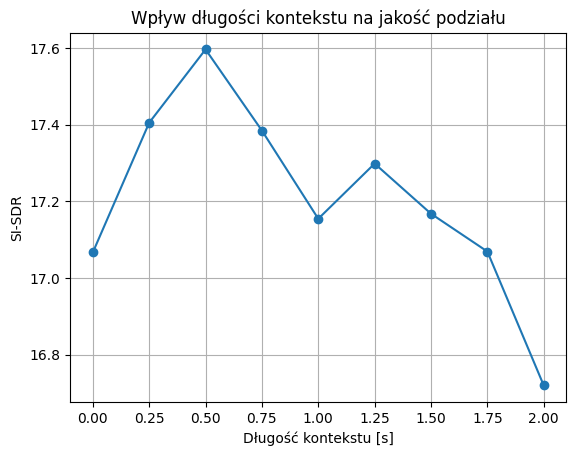

In [ ]:
import matplotlib.pyplot as plt

plt.plot([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2], results, marker='o', linestyle='-')

plt.title('Wpływ długości kontekstu na jakość podziału')
plt.xlabel('Długość kontekstu [s]')
plt.ylabel('SI-SDR')
plt.grid(True)
plt.show()